# Amazon Fine Foods Review - An EDA and Modelling 

The dataset provided to us presents the review listing of fine foods from Amazon from Oct 1999 to Oct 2012 (13 Years) . From the overview of the dataset we understand that  there are 568,454 reviews given by 256,059 users on 74,258 products with 260 users given more than  50 reviews.The dataset presents a great opportunity to explore in various dimensions like - users who always provide positive reviews , negative reviews , topic modelling , sentiment analysis etc . This kernel is an attempt in those lines .

### Import necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings 
import string
import re
import itertools
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
%matplotlib inline

## Modelling :
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,auc,roc_curve,confusion_matrix,make_scorer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


### Reading the dataset

In [2]:
### Read the dataset:
Kaggle=0
if Kaggle==0:
    review=pd.read_csv("Reviews.csv",parse_dates=["Time"])
else:
    review=pd.read_csv("../input/Reviews.csv",parse_dates=["Time"])

### Overview of the dataset

In [3]:
review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


The explanations for the variables are as follows:

* IdRow - Unique Identifier for rows
* ProductId - Unique identifier for the product
* UserId - Unqiue identifier for the user
* ProfileName - Profile name of the user
* HelpfulnessNumerator - Number of users who found the review helpful
* HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not
* Score - Rating between 1 and 5
* Time - Timestamp for the review
* Summary - Brief summary of the review
* Text - Text of the review

In [4]:
review.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score
count,568454.000000,568454.000000,568454.00000,568454.000000
mean,284227.500000,1.743817,2.22881,4.183199
std,164098.679298,7.636513,8.28974,1.310436
min,1.000000,0.000000,0.00000,1.000000
25%,142114.250000,0.000000,0.00000,4.000000
50%,284227.500000,0.000000,1.00000,5.000000
75%,426340.750000,2.000000,2.00000,5.000000
max,568454.000000,866.000000,923.00000,5.000000


From the summary statistics, we see that on an average 2 people found the review helpful and the average rating of the food has been 4.18.

### Some EDA :

In [5]:
print("There are {} unique product IDs and there are {} uniques users who have submitted their reviews.".format(review['ProductId'].nunique(),review['UserId'].nunique()))

There are 74258 unique product IDs and there are 256059 uniques users who have submitted their reviews.


Lets check the rating distribution . 

Text(0.5,1,'Distribution of Review Score')

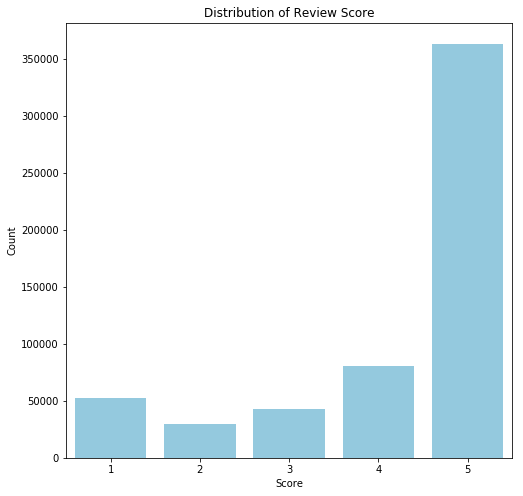

In [23]:
plt.figure(figsize=(8,8))
ax=sns.countplot(review['Score'],color='skyblue')
ax.set_xlabel("Score")
ax.set_ylabel('Count')
ax.set_title("Distribution of Review Score")

The number of reviews for rating 5 is on the higher side compared to other scores . Lets check if the rating is correlated with the helpfulness .

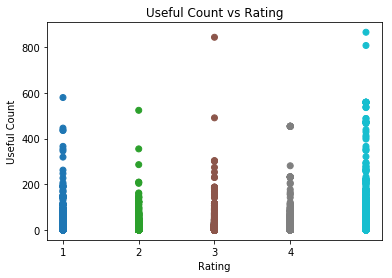

In [24]:
## Borrowed from https://www.kaggle.com/neilash/team-ndl-algorithms-and-illnesses

plt.scatter(review.Score, review.HelpfulnessDenominator, c=review.Score.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1,6)]);

In [25]:
### Borrowed from https://www.kaggle.com/neilash/team-ndl-algorithms-and-illnesses

# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 6):
    use_ls.append([i, np.sum(review[review.Score == i].HelpfulnessDenominator) / np.sum([review.Score == i])])
    
use_arr = np.asarray(use_ls)

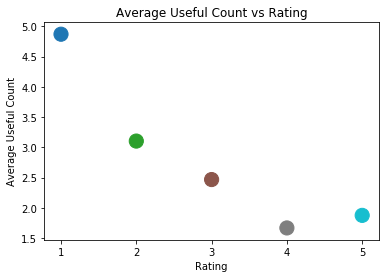

In [26]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 6)]);

It is interesting to note that there are many users who found review score 1 more helpful . I think that such reviews might have helped them to avoid a particular food.Lets check few samples of such reviews.

In [28]:
useful_rating=review.sort_values('HelpfulnessDenominator',ascending=False)


In [29]:
# Print most helpful reviews:
for i in useful_rating.Text.iloc[:3]:
    print(i,'\n')

I ordered one of these Fresh "Whole" Rabbits, but when it arrived its head, fur and insides were missing.  Not exactly whole, I'd say!  Maybe it was just damaged during shipping, but I won't be buying another one.  I mean - without the long ears, how do I know it even WAS a rabbit?  It was the same size and shape as a cat...not that I've seen a cat with its head, fur and insides missing.  I mean, not like really close or anything.<br /><br />On the plus side, it was delicious with a tall, cold glass of Tuscan Milk, so I give it three stars.  That's three WHOLE stars, BTW. 

see update at end of review<br /><br />******************<br /><br />I was lamenting about only having frech lettuce, herbs, chives, and tomatoes from may garden during the long fall-winter-spring parts of the year. The refrigerated stuff from the grocery store goes bad right away and does not taste as good as the fresh stuff from the garden, either.<br /><br />Then I saw a Time Magazine page on the new AeroGrow Aer

In [30]:
## Print least helpful reviews :
for i in useful_rating.Text.iloc[-3:]:
    print(i,'\n')

This tastes absolutely disgusting.  The package indicates it has some vitamins and health benefits, but it tastes so completely awful that you're better off buying a bottle of water and a packet of Centrum vitamins.  There is nothing about this that is remotely like acai or pomegranate.  Save yourself some money and do not buy this.  Horrible, horrible taste.<br /><br />What does it taste like, you might wonder?  You know Robutussin cherry?  Once you swallow and the cherry flavor goes away and all you are left with is the aftertaste?  This tastes like the aftertaste alone, no cherry.  Yuck yuck yuck.  (And I like Robutussin). 

I'd love to love this product, really I would.  The way it's touted, it sounds like it's energy and health in a powder!  But it, frankly, scares me a little bit.  The warning labels state that, if you take prescription drugs, you ought to think twice about drinking it.  I am on two blood pressure medications and a blood sugar medication, so I sipped a little bit

Clearly , the most helpful reviews is on the negative side which the reviewers have provided whereas the least helpful is on the neutal side -atleast from the samples part.

Lets check top 5 persons whose reviews people have found most reviews.

In [31]:
useful=review.groupby('ProfileName')['HelpfulnessDenominator'].mean().reset_index().sort_values('HelpfulnessDenominator',ascending=False)

In [32]:
useful.head()

,ProfileName,HelpfulnessDenominator
15265,"BabbChuck ""BabbChuck""",923.0
133230,P. Schmidt,878.0
17242,Benjamin Chodroff,815.0
140397,R. Hiltz,539.0
195939,"ic ""ic""",496.0


[Text(0,0,'BabbChuck "BabbChuck"'),
 Text(0,0,'P. Schmidt'),
 Text(0,0,'Benjamin Chodroff'),
 Text(0,0,'R. Hiltz'),
 Text(0,0,'ic "ic"')]

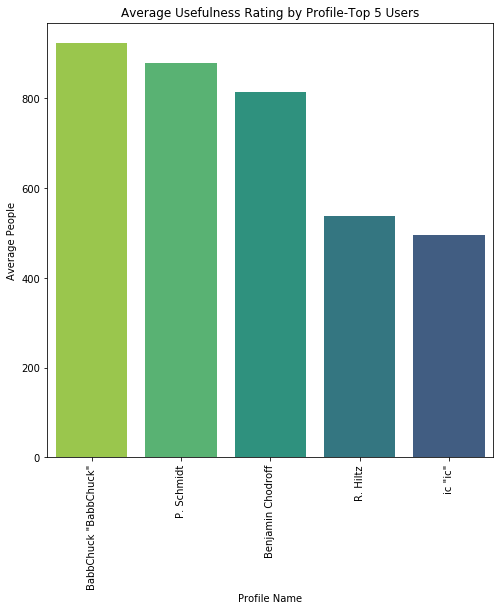

In [34]:
plt.figure(figsize=(8,8))
ax=sns.barplot(x='ProfileName',y='HelpfulnessDenominator',data=useful[:5],palette=sns.color_palette(palette="viridis_r"))
ax.set_title("Average Usefulness Rating by Profile-Top 5 Users")
ax.set_xlabel("Profile Name")
ax.set_ylabel("Average People")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

On an average 923 people have found BabbChuck "BabbChuck" review helpful and 878 people have found reviews by P. Schmidt review's helpful.

Lets check out who has consistently provided most positive scores .

In [12]:
scores=review.groupby('ProfileName')['Score'].mean().reset_index().sort_values(by='Score',ascending=False)
scores.head()

,ProfileName,Score
109208,"M. Fanelli ""mwfanelli""",5.0
125961,My Paycheck Goes To Amazon,5.0
125951,My Lady Muffins,5.0
125952,My Lisa,5.0
125953,My Local OC,5.0


[Text(0,0,'M. Fanelli "mwfanelli"'),
 Text(0,0,'My Paycheck Goes To Amazon'),
 Text(0,0,'My Lady Muffins'),
 Text(0,0,'My Lisa'),
 Text(0,0,'My Local OC'),
 Text(0,0,'My Observations'),
 Text(0,0,'My Opinion "For What It\'s Worth"'),
 Text(0,0,'My Opinion for Free'),
 Text(0,0,'My Own "Little Bill"'),
 Text(0,0,'My T. Nguyen')]

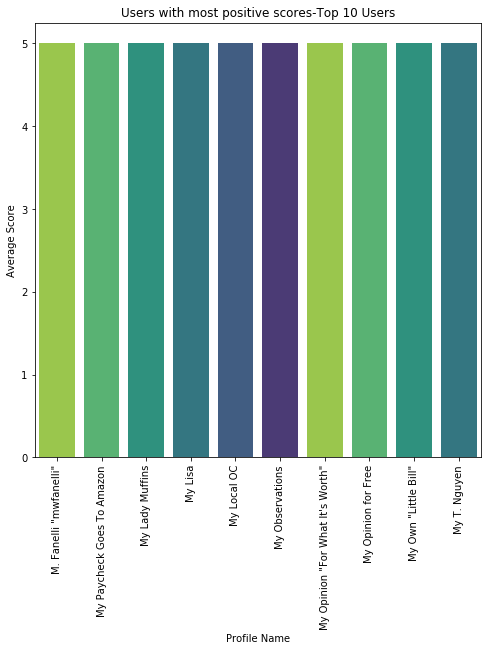

In [16]:
plt.figure(figsize=(8,8))
ax=sns.barplot(x='ProfileName',y='Score',data=scores[:10],palette=sns.color_palette(palette="viridis_r"))
ax.set_title("Users with most positive scores-Top 10 Users")
ax.set_xlabel("Profile Name")
ax.set_ylabel("Average Score")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

The plot tells us that on an average most of the users have left positive reviews in the blog . 

Lets see who has written most lengthy reviews on an average.

In [112]:
review['review_length']=review['Text'].str.len()

In [14]:
length=review.groupby('ProfileName')['review_length'].mean().reset_index().sort_values(by='review_length',ascending=False)
length.head()

,ProfileName,review_length
63,&#131;&#367;&#142;&#378;&#376; &#969;&#364;&#...,12743.5
177345,W. Christ,12331.0
177106,Vladimir Dyo,10327.0
11309,"April Vawter ""Wilderness Photographer""",9919.0
60028,Geoffrey Klos,9754.0


[Text(0,0,'&#131;&#367;&#142;&#378;&#376; &#969;&#364;&#...'),
 Text(0,0,'W. Christ'),
 Text(0,0,'Vladimir Dyo'),
 Text(0,0,'April Vawter "Wilderness Photographer"'),
 Text(0,0,'Geoffrey Klos'),
 Text(0,0,'Dan Robinson'),
 Text(0,0,'G. Zhang'),
 Text(0,0,'Iucci'),
 Text(0,0,'E. Mccloskey "EM"'),
 Text(0,0,'E. Ippolito')]

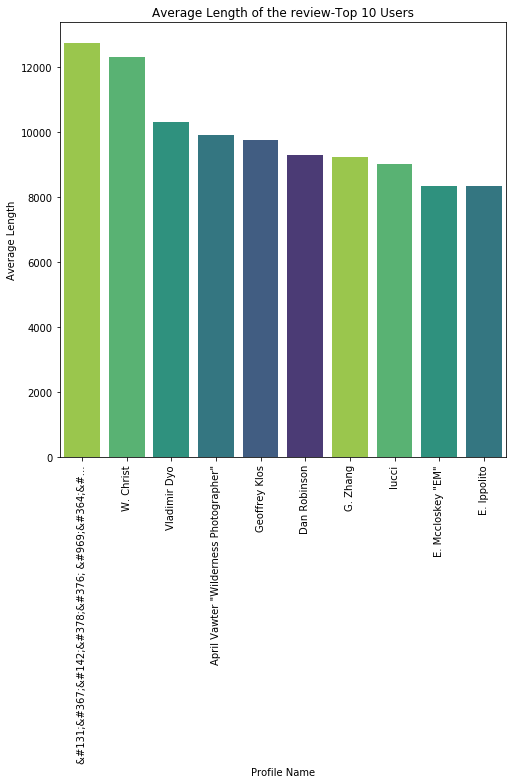

In [18]:
plt.figure(figsize=(8,8))
ax=sns.barplot(x='ProfileName',y='review_length',data=length[:10],palette=sns.color_palette(palette="viridis_r"))
ax.set_title("Average Length of the review-Top 10 Users")
ax.set_xlabel("Profile Name")
ax.set_ylabel("Average Length")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

Lets check the number of words for each score and see if there is any significant difference.

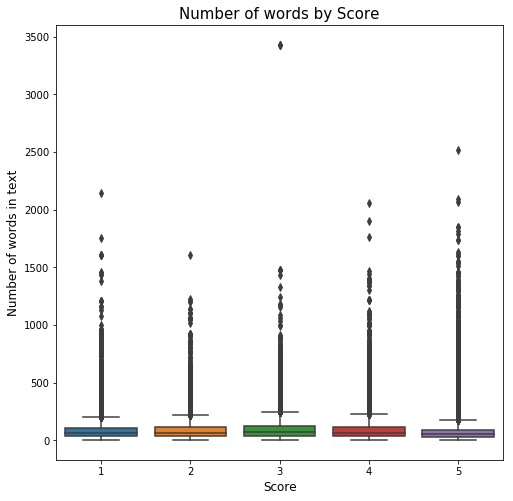

In [119]:
plt.figure(figsize=(8,8))
review['num_words']=review['Text'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='Score', y='num_words', data=review)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by Score", fontsize=15)
plt.show()

Distribution of word length over the score presents a lot of outliers . The median number of words in the text is distributed equally among the scores and there is no significant difference .

### Text Classification:

We have our scores for each of the reviews along with the review text.A model can be developed to predict the scores given the review . We first split the data to train and test .(80-20 ratio) .Considering huge size of the dataset , we sample 2L of the dataset and model the data.

In [3]:
review_sample=review.sample(10000)

In [11]:
y=review_sample['Score']
x=review_sample['Text']
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100,stratify=y)

In [12]:
print('Dimensions of train:{}'.format(X_train.shape),'\n','Dimensions of test:{}'.format(X_test.shape))

Dimensions of train:(8000,) 
 Dimensions of test:(2000,)


In [65]:
y_train.value_counts()

5    5101
4    1126
1     774
3     578
2     421
Name: Score, dtype: int64

In [100]:
y_test.value_counts()

5    1275
4     282
1     193
3     145
2     105
Name: Score, dtype: int64

We see that the scores are skewed towards the high scores therefore we can see its an imbalanced dataset.

In [13]:
y_train.describe()

count    8000.000000
mean        4.169875
std         1.327587
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Score, dtype: float64

In [14]:
### Some preprocessing exercise in train dataset: - Inspired  from https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw review), and 
    # the output is a single string (a preprocessed review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    text_words = letters_only.lower()                          
    #              
    # 
    #4.Remove stopwords and Tokenize the text
    tokens = nltk.word_tokenize(text_words)
    tokens_text = [word for word in tokens if word not in set(nltk.corpus.stopwords.words('english'))]
    #
    #5.Lemmantize using wordnetLemmantiser:
    lemmantizer=WordNetLemmatizer()
    lemma_text = [lemmantizer.lemmatize(tokens) for tokens in tokens_text]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( lemma_text ))   

Thus we have remove the HTML tags using BeautifulSoup , removed the punctuations , converted the text to lower case ,tokenized the text and used wordnet Lemmatizer after which the review text looks clean .Lets apply them all over the train data .

In [15]:
# Get the number of reviews based on the dataframe column size


# Initialize an empty list to hold the clean reviews
X_train_clean = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for text in tqdm(X_train):
    # Call our function for each one, and add the result to the list of
    # clean reviewsb
    X_train_clean.append(review_to_words(text))

100%|██████████████████████████████████████| 8000/8000 [11:05<00:00, 12.01it/s]


For modelling we use both Countvectorizer and TF-IDF models and compare the accuracy between the two.

In [35]:
#https://www.kaggle.com/nilanml/imdb-review-deep-model-94-89-accuracy
##Creating bag of words model :

vectorizer=CountVectorizer(ngram_range=(1,1),max_features=80000) 
train_feature=vectorizer.fit_transform(X_train_clean)

tfidf_transformer=TfidfVectorizer(ngram_range=(1,1))
train_feature_tfidf=tfidf_transformer.fit_transform(X_train_clean)

In [18]:
# Get the number of reviews based on the dataframe column size


# Initialize an empty list to hold the clean reviews
X_test_clean = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for text in tqdm(X_test):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    X_test_clean.append(review_to_words(text))

100%|██████████████████████████████████████| 2000/2000 [03:18<00:00, 10.09it/s]


In [36]:
test_feature=vectorizer.transform(X_test_clean)
test_feature_tfidf=tfidf_transformer.transform(X_test_clean)

In [37]:
prediction=dict()

### Naive Bayes Model

In [38]:
nb=MultinomialNB()
nb.fit(train_feature, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
prediction['Naive']=nb.predict(test_feature)

In [40]:
print(accuracy_score(y_test,prediction['Naive']))

0.668


The accuracy of the model is 66 % .Lets plot the confusion matrix.

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  62    1    2   10  118]
 [  13    1    6   13   72]
 [   7    0    7   19  112]
 [   2    0    3   35  242]
 [   7    1    2   34 1231]]


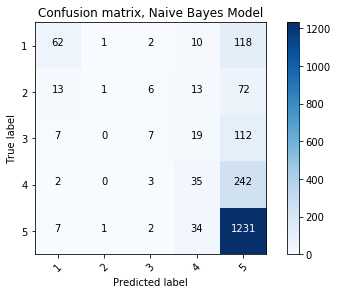

In [41]:
class_names = set(review['Score'])
cnf_matrix = confusion_matrix(y_test, prediction['Naive'])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, Naive Bayes Model')


From the confusion matrix it is seen that reviews having scores 1,2,3,4 are also predicted as 5 . This means that the model is not good enough to differentiate between the scores with the review words.

Lets check the prediction with TF-IDF model.

In [42]:
nb.fit(train_feature_tfidf,y_train)
prediction['Naive_TFIDF']=nb.predict(test_feature_tfidf)

In [43]:
print(accuracy_score(y_test,prediction['Naive_TFIDF']))

0.6375


The accuracy of the model has not improved.Infact,it has decreased.

### Logistic Regression Model

In [44]:
lr=LogisticRegression()

In [45]:
lr.fit(train_feature,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
prediction['Logit']=lr.predict(test_feature)

In [47]:
print(accuracy_score(y_test,prediction['Logit']))

0.6695


In [48]:
lr.fit(train_feature_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
prediction['Logit_TFIDF']=lr.predict(test_feature_tfidf)

In [50]:
print(accuracy_score(y_test,prediction['Logit_TFIDF']))

0.67


Both the accuracy of the model with logistic is around 67 % .

### Grid Search:

The model has been trained on an imbalanced data .Therefore lets apply oversampling methods to the dataset and retrain the model for improving the score . Also ,Lets try to improve the model with grid search.Lets create a scoring criteria first .We define accuracy score as the metric.

In [74]:
sm=SMOTE(random_state=100)

In [86]:
X_sm,y_sm=sm.fit_sample(train_feature_tfidf,y_train)

In [91]:
Counter(y_sm)

Counter({1: 5101, 2: 5101, 3: 5101, 4: 5101, 5: 5101})

Thus by using SMOTE we have oversampled the dataset to match the scores with the top score.

In [54]:
scorer=make_scorer(accuracy_score)

Lets initiate a grid search with 5 fold cross validation.

In [87]:
# parameter grid
naive=MultinomialNB()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=naive, param_grid=param_grid, scoring=scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=5)


In [88]:
# Fit Grid Search Model
model.fit(X_sm, y_sm)  # Using the TF-IDF model for training .
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    6.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished


Best score: 0.931
Best parameters set:
	alpha: 0.001


Thus by using SMOTE and cross validation we have improved the accuracy to 93 %.But since this is an imbalanced dataset , it will be wise to use metrics like confusion matrix,f1-score,precision-recall instead of accuracy score since this will be misleading. Lets apply the model to the test dataset and check the confusion matrix.

In [97]:
prediction['Naive_SMOTE']=model.predict(test_feature_tfidf)

Confusion matrix, without normalization
[[ 79  17   8  23  66]
 [ 12  15  12  17  49]
 [ 14  16  23  28  64]
 [ 16  10  28  77 151]
 [ 40  32  72 149 982]]


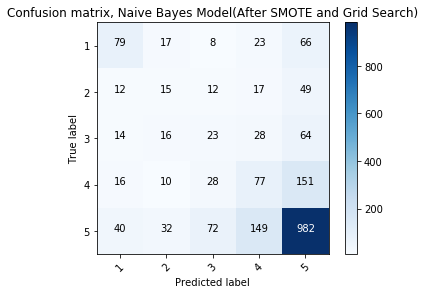

In [99]:
class_names = set(review['Score'])
cnf_matrix = confusion_matrix(y_test, prediction['Naive_SMOTE'])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, Naive Bayes Model(After SMOTE and Grid Search)')
